<a href="https://colab.research.google.com/github/grantzhou123/mnist/blob/main/MNIST%20BY%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# CNNモデルの定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# データの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNISTのデータの平均と標準偏差に基づく正規化
])

In [4]:
# MNISTデータセットのロード
train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                               transform=transform, download=True)

# DataLoaderの設定
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 42144664.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24616072.71it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11216862.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3564844.46it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# モデル、損失関数、最適化手法の設定
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# 学習率スケジューラの設定（オプショナル）
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

In [7]:
# 訓練ループ
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 訓練モードに設定
    loss_epoch = 0.0
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    scheduler.step()  # 学習率の更新
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_epoch:.4f}')

Epoch: 1/10, Loss: 1642.2933
Epoch: 2/10, Loss: 551.7734
Epoch: 3/10, Loss: 372.6508
Epoch: 4/10, Loss: 324.4454
Epoch: 5/10, Loss: 301.9901
Epoch: 6/10, Loss: 289.1421
Epoch: 7/10, Loss: 281.0123
Epoch: 8/10, Loss: 275.8249
Epoch: 9/10, Loss: 272.5162
Epoch: 10/10, Loss: 269.9552


In [8]:
# モデルの保存
torch.save(model.state_dict(), 'mnist_cnn.pth')

In [9]:
# 訓練データとテストデータでのモデルの評価
def evaluate_model(loader):
    model.eval()  # 評価モードに設定
    labels_true = []
    labels_pred = []
    with torch.no_grad():
        for img, label in loader:
            labels_true.extend(label.numpy())
            img, label = img.to(device), label.to(device)
            output = model(img)
            _, pred = torch.max(output.data, 1)
            pred = pred.cpu().numpy()
            labels_pred.extend(pred)
    print(confusion_matrix(labels_true, labels_pred))
    print(classification_report(labels_true, labels_pred))

In [10]:
print("訓練データでの評価:")
evaluate_model(train_loader)

訓練データでの評価:
[[5709    4   16   12    6   38   47    9   74    8]
 [   1 6531   56   26    9   36    7   13   54    9]
 [  46   36 5332   83  131   14   87  100  116   13]
 [  22   47  128 5456    6  197   18   85  116   56]
 [   5   21   59    2 5331    2   88   13   33  288]
 [  42   42   34  140   92 4867   73   15   73   43]
 [  45   55   32    0   42   92 5623    2   27    0]
 [  17   55  103   17   51   13    0 5769   10  230]
 [  23  123   49  151   41  107   26   19 5204  108]
 [  36   38   44   97  156   20    3  182   51 5322]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5923
           1       0.94      0.97      0.95      6742
           2       0.91      0.89      0.90      5958
           3       0.91      0.89      0.90      6131
           4       0.91      0.91      0.91      5842
           5       0.90      0.90      0.90      5421
           6       0.94      0.95      0.95      5918
           7       0.93  

In [11]:
print("テストデータでの評価:")
evaluate_model(test_loader)

テストデータでの評価:
[[ 961    0    0    0    0    4    8    1    6    0]
 [   0 1110    4    3    1    1    3    0   13    0]
 [  10    1  930   15   14    1   13   18   28    2]
 [   3    2   20  925    0   20    0   15   19    6]
 [   1    3    5    0  906    0   16    1    5   45]
 [   8    3    5   31   11  799   12    1   17    5]
 [  12    6    3    1   11   20  905    0    0    0]
 [   0   11   27    4    7    1    0  927    4   47]
 [   7    7    6   22   12   17    5   11  874   13]
 [   7    6    7   10   24   10    0   17    8  920]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.91      0.92      0.92      1010
           4       0.92      0.92      0.92       982
           5       0.92      0.90      0.91       892
           6       0.94      0.94      0.94       958
           7       0.94 

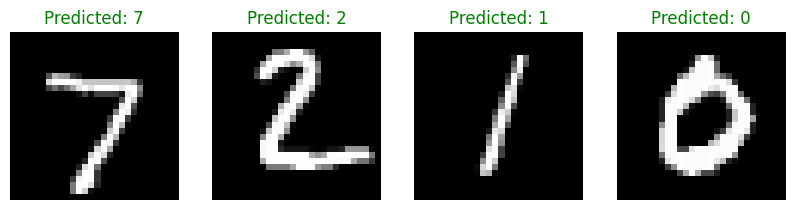

In [12]:
# 単一画像に対するモデルの予測を表示する関数
def show_prediction_example(loader):
    model.eval()  # 評価モードに設定
    images, labels = next(iter(loader))  # データローダーから一批のデータを取得

    # GPUが利用可能な場合は、画像をGPUに移動
    images, labels = images.to(device), labels.to(device)
    output = model(images)  # モデルで予測
    _, preds = torch.max(output, 1)  # 最も高い確率を持つクラスを予測ラベルとして選択

    # 予測結果の表示
    plt.figure(figsize=(10, 4))
    for idx in np.arange(4):  # 最初の4つの画像と予測ラベルを表示
        ax = plt.subplot(1, 4, idx+1)
        img = images[idx].cpu().numpy().squeeze()  # 画像を表示用に変換
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Predicted: {preds[idx].item()}", color=("green" if preds[idx]==labels[idx] else "red"))
        ax.axis('off')
    plt.show()

# テストデータローダーを使用して予渲例を表示
show_prediction_example(test_loader)
